In [26]:
import os
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
import pyspark.sql.functions as sql_fun
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 4)
sns.set(style='darkgrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', UserWarning)

In [2]:
dataPath = r'/home/daniel/Desktop/programming/pythondatascience/datascience/dataengineering/datasets/movieLens25m/'
movies = os.path.join(dataPath, 'movies.csv')
ratings = os.path.join(dataPath, 'ratings.csv')
tags = os.path.join(dataPath, 'tags.csv')

spark = SparkSession.builder.appName('recommender').getOrCreate()
movies = spark.read.csv(movies, inferSchema = True, header = True)
ratings = spark.read.csv(ratings, inferSchema = True, header = True)
# tags = spark.read.csv(tags, inferSchema = True, header = True)

22/06/12 15:27:54 WARN Utils: Your hostname, daniel-X555LJ resolves to a loopback address: 127.0.1.1; using 10.0.3.1 instead (on interface lxcbr0)
22/06/12 15:27:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/12 15:27:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# We will only work with 5 million records
ratings = ratings.limit(5000000)
print(f"There are {movies.count()} records present in the dataset")
print(f"There are {ratings.count()} records present in the dataset")

There are 62423 records present in the dataset


There are 5000000 records present in the dataset


In [4]:
movies.printSchema()
ratings.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [5]:
print(f"Number of partitions for movies DataFrame: {movies.rdd.getNumPartitions()}")
print(f"Number of partitions for ratings DataFrame: {ratings.rdd.getNumPartitions()}")

Number of partitions for movies DataFrame: 1
Number of partitions for ratings DataFrame: 1


## Load the movies and ratings Dataset in memory to improve performance

In [6]:
ratings=ratings.repartition(10).cache()
movies=movies.repartition(10).cache()
# Create a repartitioned rating DataFrame across 10 partitions
repartitionedRatingdf = ratings.repartition(10)
print(f"Number of partitions for ratings DataFrame: {ratings.rdd.getNumPartitions()}")
print(f"Number of partitions for the movies DataFrame: {movies.rdd.getNumPartitions()}")

Number of partitions for ratings DataFrame: 10
Number of partitions for the movies DataFrame: 10


# Exploratory Data Analysis

In [7]:
movies.show(truncate=False)

+-------+----------------------------------------------------+-----------------------------+
|movieId|title                                               |genres                       |
+-------+----------------------------------------------------+-----------------------------+
|164505 |Sioux City (1994)                                   |Drama|Thriller               |
|166179 |The Secret Garden (1987)                            |Children|Drama               |
|158773 |State of Dogs (1998)                                |(no genres listed)           |
|137018 |A Sister's Revenge (2013)                           |Drama|Mystery|Thriller       |
|162888 |Frankie Boyle - Live - The Last Days of Sodom (2012)|Comedy                       |
|142997 |Hotel Transylvania 2 (2015)                         |Animation|Comedy             |
|132268 |Miranda (1985)                                      |Comedy|Romance               |
|151347 |Ah Boys To Men (Part 1) (2012)                      |(no genr

In [8]:
ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
| 22386|   1247|   2.0|1403332463|
| 26130|   1196|   4.5|1433335396|
|  3242|   5952|   2.0|1463842760|
| 11940|   1265|   3.0| 939320200|
|  6179|   1135|   3.0| 852491990|
|  6211|   1193|   4.0|1260752276|
| 20991|   1097|   5.0|1160082151|
| 16783|  72011|   3.0|1497643469|
| 13727|    507|   4.0|1066915111|
| 13564|   4963|   5.0|1443812420|
| 24467|   2871|   5.0|1553786422|
| 22821|   3996|   3.0|1143229245|
| 27130|   2694|   1.5|1119742271|
| 32064|   5867|   3.0|1145628948|
| 20823|  30707|   4.5|1179225765|
| 32367|   5618|   3.0|1508555110|
|  6553|  58998|   2.0|1556416321|
| 24523|   1206|   3.0|1561854339|
|  4388|   3448|   4.5|1149206077|
| 12587|   1288|   3.0| 848327476|
+------+-------+------+----------+
only showing top 20 rows



In [9]:
ratings.describe().show()

+-------+-----------------+------------------+-----------------+--------------------+
|summary|           userId|           movieId|           rating|           timestamp|
+-------+-----------------+------------------+-----------------+--------------------+
|  count|          5000000|           5000000|          5000000|             5000000|
|   mean|     16532.768653|     21624.1973554|        3.5314428|1.2169214102978714E9|
| stddev|9412.793911649658|39525.607518551005|1.063326937710594|2.2761449383681694E8|
|    min|                1|                 1|              0.5|           789652009|
|    max|            32564|            209163|              5.0|          1574327549|
+-------+-----------------+------------------+-----------------+--------------------+



# Check Data Sparcity

**Check the Sparcity of the Data i.e check the percentage of missing data present in the dataset**

In [10]:
# Count the number of ratings in the dataset
numerator = ratings.select('rating').count()

# Count the number of distinct userId and movieId
num_users = ratings.select('userId').distinct().count()
num_movies = ratings.select('movieId').distinct().count()

# Set the denominator by multipling the number of users by the number of movies
denominator = num_users * num_movies

# Divide the numerator by the denominator(1.0 is to ensure that the sparcity 
# is returned as decimal not integer)
sparcity = (1.0 - (numerator * 1.0) / denominator)*100

print(f"The ratings Dataframe is {sparcity:.2f}% empty.")

The ratings Dataframe is 99.60% empty.


That's a lot of missing data

# Summary Statistics

In [11]:
# Group data by userId count ratings
ratings.groupby("userId").count().show()

+------+-----+
|userId|count|
+------+-----+
| 16861|   93|
| 19079|  458|
| 26623|  164|
| 26087| 1020|
| 29054| 3069|
| 19530|  106|
| 27760|  965|
| 18944|   70|
| 10623| 1629|
| 32460|   37|
|  9852| 1801|
| 18911|  349|
| 11033|  170|
| 29814|   77|
| 10206|  110|
| 31912|   21|
| 30970|  567|
| 18866|  141|
| 22521|  242|
| 17420|   35|
+------+-----+
only showing top 20 rows



In [12]:
# Movies with the fewest ratings
ratings.groupBy("movieId").count().select(sql_fun.min('count')).show()

+----------+
|min(count)|
+----------+
|         1|
+----------+



In [13]:
# Average number of ratings per movie
ratings.groupBy('movieId').count().select(sql_fun.avg('count')).show()

+------------------+
|        avg(count)|
+------------------+
|128.68356710848025|
+------------------+



In [14]:
# Another way of getting the movie average
ratings.groupBy("movieId").count().agg({"count":"avg"}).show()

+------------------+
|        avg(count)|
+------------------+
|128.68356710848025|
+------------------+



In [15]:
# Users with the fewest ratings
ratings.groupby('userId').count().select(sql_fun.min('count')).show()

+----------+
|min(count)|
+----------+
|        20|
+----------+



In [16]:
# Average number of ratings per users
ratings.groupby('userId').count().select(sql_fun.avg('count')).show()

+------------------+
|        avg(count)|
+------------------+
|153.54379068910453|
+------------------+



Users have atleast 20 ratings on an average of 153.5 ratings. And movies have atleast 1 rating with an average of 128.6 ratings.

In [17]:
print(f"Number of different Users: {num_users}")
print(f"Number of different Movies: {num_movies}")
print(f"Number of movies with ratings higher than 4: {ratings.filter(ratings.rating > 4).select('movieId').distinct().count()}")

Number of different Users: 32564
Number of different Movies: 38855
Number of movies with ratings higher than 4: 18913


In [18]:
# Ratings higher than 4 again in SQL.
ratings.createOrReplaceTempView('ratings')
spark.sql("SELECT COUNT(DISTINCT(movieId)) FROM ratings WHERE rating > 4").show()

+-----------------------+
|count(DISTINCT movieId)|
+-----------------------+
|                  18913|
+-----------------------+



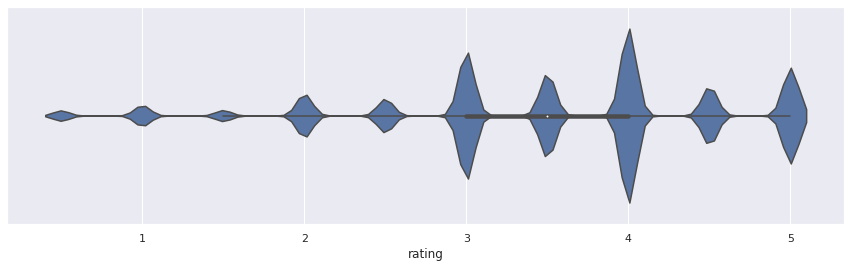

In [19]:
ratPd = ratings.toPandas()
sns.violinplot(x='rating', data=ratPd, kind='count')
plt.show()

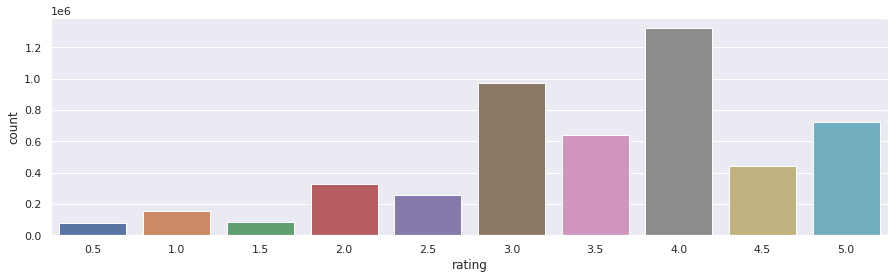

In [20]:
sns.countplot(x='rating', data=ratPd)
plt.show()

Majority of the movies rated by users is 4.

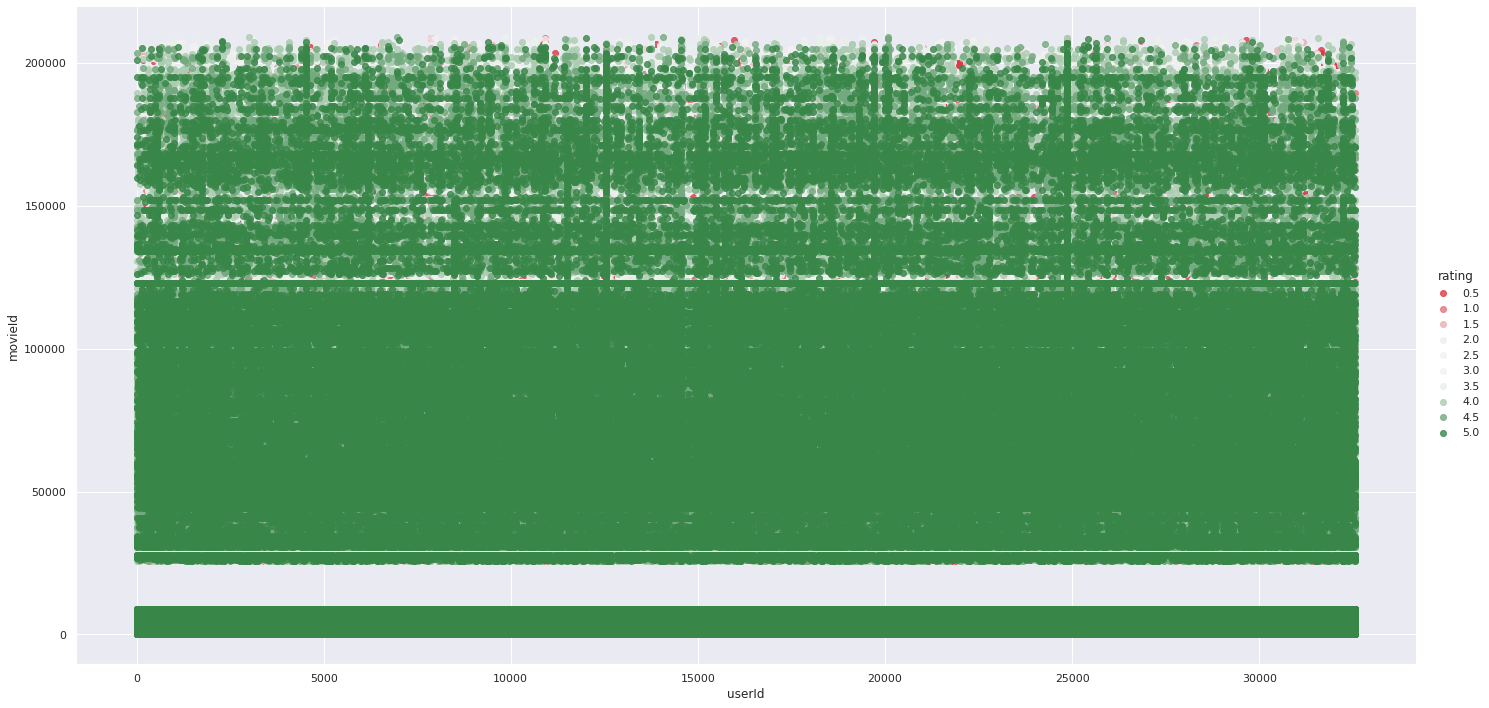

In [21]:
lm = sns.lmplot(y='movieId', x='userId', 
                data=ratPd, hue='rating', 
                fit_reg=False, height=10, aspect=2, 
                palette=sns.diverging_palette(10, 133, sep=80, n=10))
plt.show()

Notice there are some data missing between movies 0 and 20000, this might because we are using 1million records. Most movies are rated from 3.5 - 5 and some movies are rated alot this could be that those movies are more famous.

# Build the Recommender System

`There are 3 methods of building recommender systems;`
- User-based
- Content-based
- Collaborative filtering

`Collaborative filtering` calculates recommendations based on similarities between users and products. For example, collaborative filtering assumes that users who gives similar ratings on the same movies will also have similar opinions on movies that they haven't seen.

The alternating least squares (ALS) algorithm provides collaborative filtering between users and products to find products that the customers might like, based on their previous ratings.

In [22]:
spark.sql("""

SELECT *, 100*nb_ratings/matrix_size AS percentage

    FROM (
        SELECT nb_ratings, nb_movies, nb_users, nb_ratings*nb_movies AS matrix_size

            FROM (
                SELECT COUNT(*) AS nb_ratings, COUNT(DISTINCT(movieId)) AS nb_movies, COUNT(DISTINCT(userId)) AS nb_users 
        
                    FROM ratings))

""").show()

+----------+---------+--------+------------+--------------------+
|nb_ratings|nb_movies|nb_users| matrix_size|          percentage|
+----------+---------+--------+------------+--------------------+
|   5000000|    38855|   32564|194275000000|0.002573671342169...|
+----------+---------+--------+------------+--------------------+



Less than 1% of the matrix is filled.

# Split the Data and build a Base ALS Model

# Predictions and Evaluate the Base Model on Test data

In [23]:
(train_data, test_data) = ratings.randomSplit([0.80, 0.20], seed = 42)

base = ALS(userCol='userId',
           itemCol='movieId', 
           ratingCol='rating', 
           nonnegative=True, 
           implicitPrefs=False)

# Replacing the non-rated movies with average ratings
avgRatings = ratings.select('rating').groupBy().avg().first()[0]
print(f'The average rating in the dataset is: {avgRatings}')
# Fit the model
baseModel = base.fit(train_data)
# Generate predictions on the test data
test_preds = baseModel.transform(test_data)
rmse = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
r2 = RegressionEvaluator(metricName='r2', labelCol='rating', predictionCol='prediction')
print(f"The root mean squared error for the base model is: {rmse.evaluate(test_preds.na.fill(avgRatings))}")
print(f"The r-squared error for the base model is: {r2.evaluate(test_preds.na.fill(avgRatings))}")
test_preds.show(5)

The average rating in the dataset is: 3.5314428


The root mean squared error for the base model is: 0.8236913460218541


The r-squared error for the base model is: 0.3991821400121087


+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     1|   7327|   3.5|1147868855| 4.0357985|
|     1|   8729|   3.5|1147878452|  3.193542|
|     2|    266|   1.0|1141415926| 3.3054442|
|     2|   1283|   4.0|1141416205| 3.5841508|
|     2|   2083|   4.5|1141417581| 3.4960365|
+------+-------+------+----------+----------+
only showing top 5 rows



In [24]:
base2 = ALS(userCol='userId',
            itemCol='movieId', 
            ratingCol='rating', 
            nonnegative=True, 
            implicitPrefs=False, 
            coldStartStrategy='drop'
           )

# Fit the model
baseModel = base2.fit(train_data)
# Generate predictions on the test data
test_preds = baseModel.transform(test_data)
rmse = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
r2 = RegressionEvaluator(metricName='r2', labelCol='rating', predictionCol='prediction')
print(f"The root mean squared error for the base model is: {rmse.evaluate(test_preds)}")
print(f"The r-squared error for the base model is: {r2.evaluate(test_preds)}")
test_preds.show(5)

The root mean squared error for the base model is: 0.821896326495646


The r-squared error for the base model is: 0.40088992295882475


+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   148|   1213|   4.5|1454942639| 4.1394796|
|   148|   1234|   4.5|1454943122|  4.097252|
|   148|   1284|   4.0|1454943174|  4.024712|
|   148|  48516|   4.5|1454942659|  4.037862|
|   148| 116897|   4.0|1454942698| 4.0810676|
+------+-------+------+----------+----------+
only showing top 5 rows



As seen above our base model with the average rating performed better than the base2, we will tune the hyperparameters of the base model(the first model) with cross validation to improve the performance of the model.

# Model Hyperparameter tuning of the Base model

In [25]:
# param_grid = ParamGridBuilder().addGrid(base.rank, [
#     5, 10
# ]).addGrid(base.maxIter, [
#     15
# ]).addGrid(base.regParam, [
#     0.05, 0.1, 0.5
# ]).build()

# rmse = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# cv = CrossValidator(estimator=base2, 
#                     estimatorParamMaps=param_grid, 
#                     evaluator=rmse, 
#                     numFolds=5)

# print(f"Number of models to be tested: {len(param_grid)}")

Number of models to be tested: 6


In [26]:
# %%time
# cvModel = cv.fit(train_data)
# # Extract the best model hyperparameter for training
# best_model = cvModel.bestModel
# print(f"Best model hyperparameter is:\n \nRank: {best_model.rank}, MaxIter: {best_model._java_obj.parent().getMaxIter()}, RegParam: {best_model._java_obj.parent().getRegParam()}")

Best model hyperparameter is:
 
Rank: 10, MaxIter: 10, RegParam: 0.1
CPU times: user 5.05 s, sys: 1.23 s, total: 6.28 s
Wall time: 35min 45s


Best model hyperparameter is:
 
Rank: 10, MaxIter: 10, RegParam: 0.1
CPU times: user 5.05 s, sys: 1.23 s, total: 6.28 s
Wall time: 35min 45s

# Model Selection

In [25]:
als = ALS(maxIter=10,
          regParam=0.1, 
          rank=10,
          userCol='userId',
          itemCol='movieId', 
          ratingCol='rating', 
          nonnegative=True, 
          implicitPrefs=False, 
          coldStartStrategy='drop')

# Fit the model
model = als.fit(train_data)
# Generate predictions on the test data
test_preds = model.transform(test_data)
rmse = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
r2 = RegressionEvaluator(metricName='r2', labelCol='rating', predictionCol='prediction')
print(f"The root mean squared error for the base model is: {rmse.evaluate(test_preds)}")
print(f"The r-squared error for the base model is: {r2.evaluate(test_preds)}")
test_preds.show(5)

The root mean squared error for the base model is: 0.821896326495646


The r-squared error for the base model is: 0.40088992295882475


+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   148|   1213|   4.5|1454942639| 4.1394796|
|   148|   1234|   4.5|1454943122|  4.097252|
|   148|   1284|   4.0|1454943174|  4.024712|
|   148|  48516|   4.5|1454942659|  4.037862|
|   148| 116897|   4.0|1454942698| 4.0810676|
+------+-------+------+----------+----------+
only showing top 5 rows



In [32]:
preds = test_preds.withColumn("predictions", sql_fun.round(sql_fun.col("prediction"), 4))
orig_ratings = ratings.join(movies, ratings.movieId==movies.movieId).select(ratings.userId, 
                                                                            ratings.movieId, 
                                                                            movies.title, 
                                                                            movies.genres, 
                                                                            ratings.rating)
# Join the predicted rating with the respectively users
recommendation = preds.join(movies, preds.movieId==movies.movieId).select(preds.userId, 
                                                                          preds.movieId, 
                                                                          movies.title, 
                                                                          movies.genres, 
                                                                          preds.predictions)

print("Rating")
orig_ratings.show(truncate=False)
print("Recommendation")
recommendation.show(truncate=False, vertical=True)

Rating
+------+-------+-------------------------------------------------------+---------------------------+------+
|userId|movieId|title                                                  |genres                     |rating|
+------+-------+-------------------------------------------------------+---------------------------+------+
|22386 |1247   |Graduate, The (1967)                                   |Comedy|Drama|Romance       |2.0   |
|26130 |1196   |Star Wars: Episode V - The Empire Strikes Back (1980)  |Action|Adventure|Sci-Fi    |4.5   |
|3242  |5952   |Lord of the Rings: The Two Towers, The (2002)          |Adventure|Fantasy          |2.0   |
|11940 |1265   |Groundhog Day (1993)                                   |Comedy|Fantasy|Romance     |3.0   |
|6179  |1135   |Private Benjamin (1980)                                |Comedy                     |3.0   |
|6211  |1193   |One Flew Over the Cuckoo's Nest (1975)                 |Drama                      |4.0   |
|20991 |1097   |E.T. 

-RECORD 0-----------------------------------------------------------------------------
 userId      | 148                                                                    
 movieId     | 1213                                                                   
 title       | Goodfellas (1990)                                                      
 genres      | Crime|Drama                                                            
 predictions | 4.1395                                                                 
-RECORD 1-----------------------------------------------------------------------------
 userId      | 148                                                                    
 movieId     | 1234                                                                   
 title       | Sting, The (1973)                                                      
 genres      | Comedy|Crime                                                           
 predictions | 4.0973                      

# Do the Recommendation make sense?

Let's actually look at recommendations made to a user(22386, 26130) and see if they make sense

In [33]:
orig_ratings.filter(orig_ratings.userId==22386).sort('rating', ascending=False).show(10, truncate=False)

+------+-------+--------------------------+------------------------+------+
|userId|movieId|title                     |genres                  |rating|
+------+-------+--------------------------+------------------------+------+
|22386 |40629  |Pride & Prejudice (2005)  |Drama|Romance           |5.0   |
|22386 |106920 |Her (2013)                |Drama|Romance|Sci-Fi    |5.0   |
|22386 |58559  |Dark Knight, The (2008)   |Action|Crime|Drama|IMAX |5.0   |
|22386 |3504   |Network (1976)            |Comedy|Drama            |5.0   |
|22386 |1925   |Wings (1927)              |Action|Drama|Romance|War|5.0   |
|22386 |55290  |Gone Baby Gone (2007)     |Crime|Drama|Mystery     |5.0   |
|22386 |88950  |Conspirator, The (2010)   |Drama                   |5.0   |
|22386 |71464  |Serious Man, A (2009)     |Comedy|Drama            |5.0   |
|22386 |1784   |As Good as It Gets (1997) |Comedy|Drama|Romance    |5.0   |
|22386 |1035   |Sound of Music, The (1965)|Musical|Romance         |5.0   |
+------+----

In [34]:
recommendation.filter(recommendation.userId==22386).show(10, truncate=False)

+------+-------+-----------------------------------------+--------------------------------+-----------+
|userId|movieId|title                                    |genres                          |predictions|
+------+-------+-----------------------------------------+--------------------------------+-----------+
|22386 |236    |French Kiss (1995)                       |Action|Comedy|Romance           |2.7687     |
|22386 |260    |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi         |3.5865     |
|22386 |344    |Ace Ventura: Pet Detective (1994)        |Comedy                          |2.3087     |
|22386 |368    |Maverick (1994)                          |Adventure|Comedy|Western        |2.8693     |
|22386 |786    |Eraser (1996)                            |Action|Drama|Thriller           |2.4721     |
|22386 |1221   |Godfather: Part II, The (1974)           |Crime|Drama                     |3.6335     |
|22386 |1245   |Miller's Crossing (1990)                 |Crime|

In [35]:
orig_ratings.filter(orig_ratings.userId==26130).sort('rating', ascending=False).show(10, 
                                                                                     truncate=False, 
                                                                                     vertical=True)

-RECORD 0--------------------------------------------------------
 userId  | 26130                                                 
 movieId | 109487                                                
 title   | Interstellar (2014)                                   
 genres  | Sci-Fi|IMAX                                           
 rating  | 5.0                                                   
-RECORD 1--------------------------------------------------------
 userId  | 26130                                                 
 movieId | 48738                                                 
 title   | Last King of Scotland, The (2006)                     
 genres  | Drama|Thriller                                        
 rating  | 5.0                                                   
-RECORD 2--------------------------------------------------------
 userId  | 26130                                                 
 movieId | 7153                                                  
 title   |

In [36]:
recommendation.filter(recommendation.userId==26130).show(10, truncate=False)

+------+-------+-----------------------------------------------------+------------------------------+-----------+
|userId|movieId|title                                                |genres                        |predictions|
+------+-------+-----------------------------------------------------+------------------------------+-----------+
|26130 |1196   |Star Wars: Episode V - The Empire Strikes Back (1980)|Action|Adventure|Sci-Fi       |4.0995     |
|26130 |5956   |Gangs of New York (2002)                             |Crime|Drama                   |3.5325     |
|26130 |7153   |Lord of the Rings: The Return of the King, The (2003)|Action|Adventure|Drama|Fantasy|4.2683     |
|26130 |4973   |Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) |Comedy|Romance                |3.8463     |
|26130 |1210   |Star Wars: Episode VI - Return of the Jedi (1983)    |Action|Adventure|Sci-Fi       |4.0686     |
|26130 |5418   |Bourne Identity, The (2002)                          |Action|Mystery|Thr

The recommendation given to users with id 22386 and 26130 makes sense. Therefore, we will serilaize this model for future recommendations

In [31]:
# Serialize the model to disk
model.save("modelV1.model")